Using TensorFlow backend.


1. Number of Driving Records: 3528
---------------------------------------
2. Basic Statistics of Driving Records:
       Steering Angle  Throttle    Break    Speed
count        3,528.00  3,528.00 3,528.00 3,528.00
mean            -0.04      0.95     0.00    29.25
std              0.23      0.22     0.00     4.43
min             -1.00      0.00     0.00     0.00
25%              0.00      1.00     0.00    30.17
50%              0.00      1.00     0.00    30.19
75%              0.00      1.00     0.00    30.19
max              1.00      1.00     0.00    30.39
---------------------------------------
3. Types of Input Columns from Driving Records:
Center Image       object
Left Image         object
Right Image        object
Steering Angle    float64
Throttle          float64
Break               int64
Speed             float64
dtype: object
---------------------------------------
4. Plots of Input Driving Records:


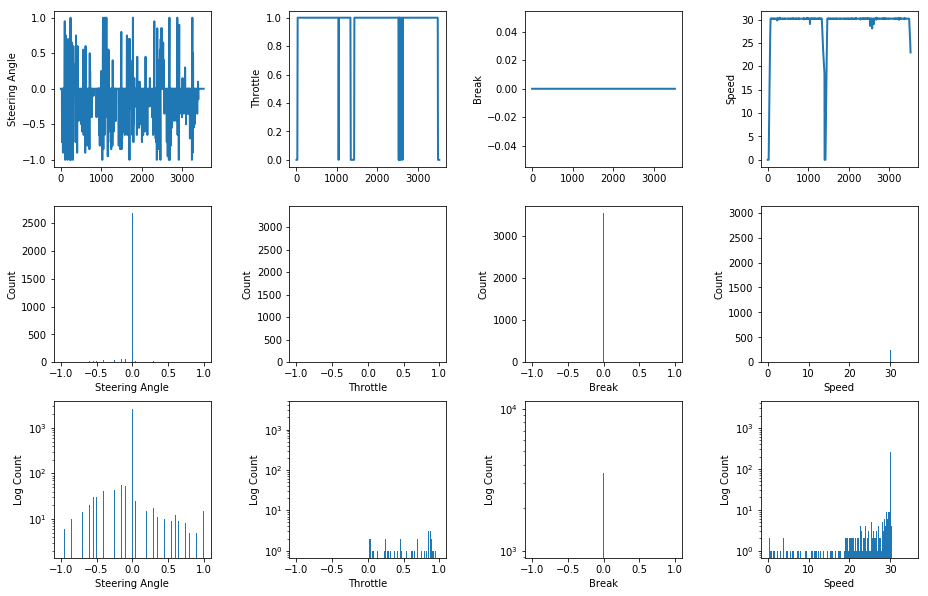

5. Sample images from simulation:
Sample Image shape:  (160, 320, 3)


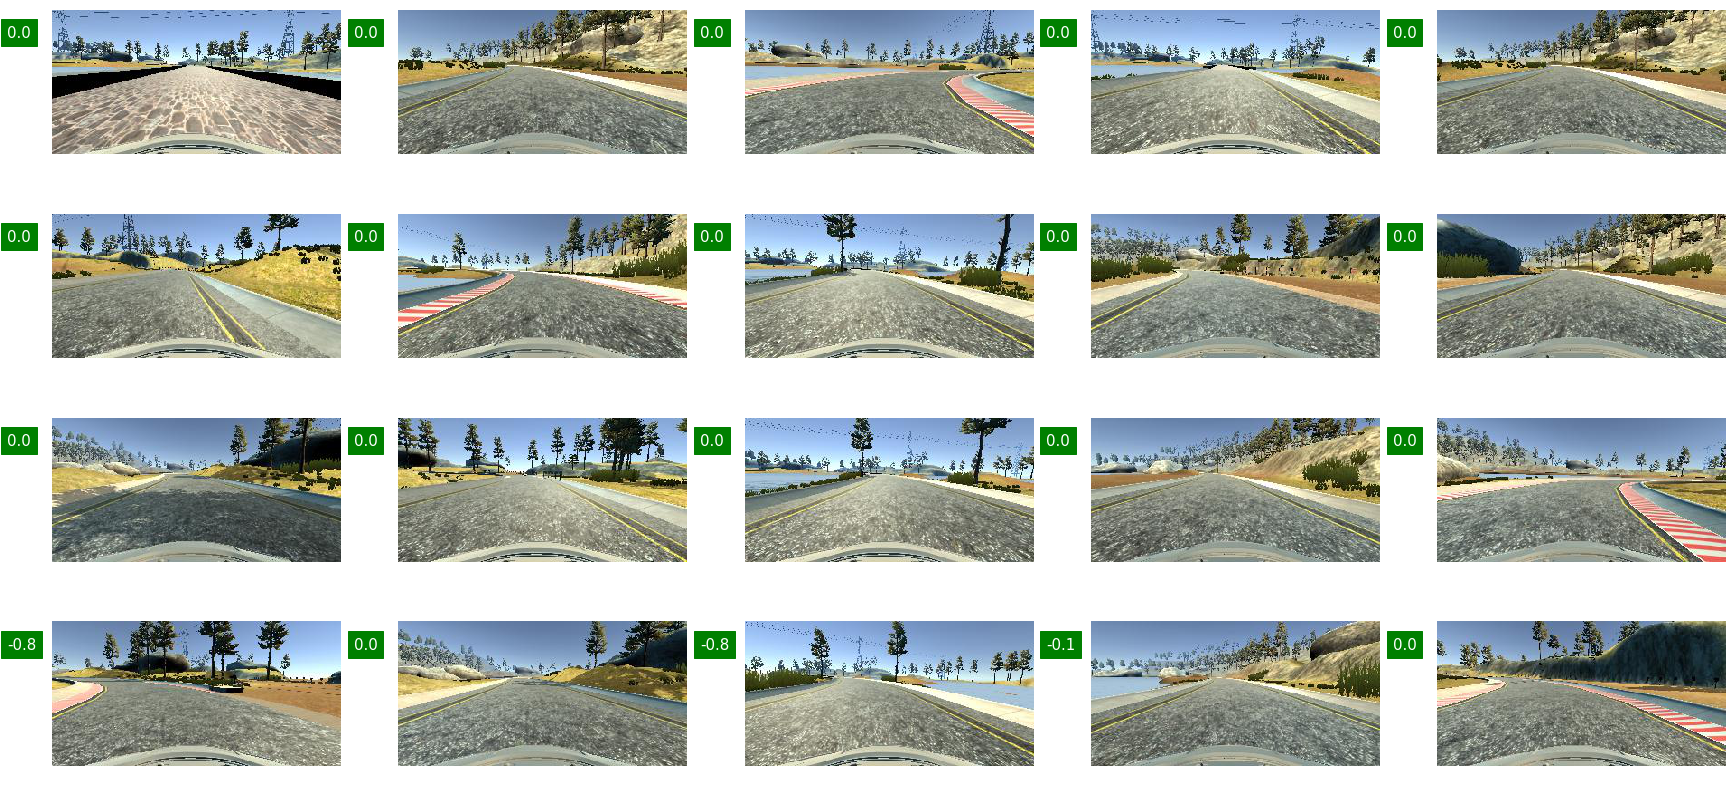

In [1]:
## Initializations of packages/parameters/path
import os,cv2,json,time,csv
from pathlib import Path
import numpy as np
from numpy.random import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, ELU ,Lambda 
from keras.utils import np_utils
from keras.optimizers import Adam

DrivingLog = './driving_log.csv'
OutputModelJson = 'model.json'
OutputModelH5 = 'model.h5'

batch_size = 32
nb_classes = 1
nb_epoch = 100
channel,rows, cols = 3, 160, 320 
input_shape=(channel,rows,cols)
pool_size = (2, 3)


# Pre-defined Functions
# Crop the image by its top one third
def locrop_image(imgpath):
    imagepath = imgpath.replace(' ','')
    image = cv2.imread(imagepath, 1)
    shape = image.shape
    image = image[int(shape[0]/3):shape[0], 0:shape[1]]
    image = cv2.resize(image, (rows, cols), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return image

# Image generator.
def image_generator(X, Y, rows, cols, channel):  
    while 1:
        for i in range(len(X)):
            y = Y[i]
            if y < -0.01:
                rdm = random()
                if rdm > 0.75:
                    imgpath = X[i].split('?')[1]
                    y *= 3.0
                else:
                    if rdm > 0.5:
                        imgpath = X[i].split('?')[1]
                        y *= 2.0
                    else:
                        if rdm > 0.25:
                            imgpath = X[i].split('?')[0]
                            y *= 1.5
                        else:
                            imgpath = X[i].split('?')[0]
            else:
                if y > 0.01:
                    rdm = random()
                    if rdm > 0.75:
                        imgpath = X[i].split('?')[2]
                        y *= 3.0
                    else:
                        if rdm > 0.5:
                            imgpath = X[i].split('?')[2]
                            y *= 2.0
                        else:
                            if rdm > 0.25:
                                imgpath = X[i].split('?')[0]
                                y *= 1.5
                            else:
                                imgpath = X[i].split('?')[0]
                else:
                    imgpath = X[i].split('?')[0]
            
            ximage = locrop_image(imgpath)
            y_train = np.array([[y]])
            x_train = ximage.reshape(1,channel, rows, cols)
            yield x_train, y_train
            
## Pre-processing Data
## Before we start to process the data, we would like to analyze the driving_csv log
## features: center,left,right,steering,throttle,brake,speed

Col_Names=['Center Image','Left Image','Right Image','Steering Angle','Throttle','Break','Speed']
driving_csv = pd.read_csv(DrivingLog,header=None,names=Col_Names)
print("1. Number of Driving Records: %d" % len(driving_csv))
print("---------------------------------------")
print("2. Basic Statistics of Driving Records:")
pd.options.display.float_format = '{:,.2f}'.format
print(driving_csv.describe())
print("---------------------------------------")
print("3. Types of Input Columns from Driving Records:")
print(driving_csv.dtypes)
print("---------------------------------------")
print("4. Plots of Input Driving Records:")

plt.figure(1)
linewidth=2
bins=np.linspace(-1, 1, 250)
speedbins=np.linspace(0,35,210)


plt.subplot(341)
plt.plot(driving_csv['Steering Angle'],lw=linewidth)
plt.ylabel('Steering Angle')
plt.subplot(342)
plt.plot(driving_csv['Throttle'],lw=linewidth)
plt.ylabel('Throttle')
plt.subplot(343)
plt.plot(driving_csv['Break'],lw=linewidth)
plt.ylabel('Break')
plt.subplot(344)
plt.plot(driving_csv['Speed'],lw=linewidth)
plt.ylabel('Speed')

plt.subplot(345)
plt.hist(driving_csv['Steering Angle'],bins)
plt.ylabel('Count')
plt.xlabel('Steering Angle')
plt.subplot(346)
plt.hist(driving_csv['Throttle'],bins)
plt.ylabel('Count')
plt.xlabel('Throttle')
plt.subplot(347)
plt.hist(driving_csv['Break'],bins)
plt.ylabel('Count')
plt.xlabel('Break')
plt.subplot(348)
plt.hist(driving_csv['Speed'],speedbins)
plt.ylabel('Count')
plt.xlabel('Speed')

plt.subplot(3,4,9)
plt.hist(driving_csv['Steering Angle'],bins)
plt.ylabel('Log Count')
plt.xlabel('Steering Angle')
plt.yscale('log', nonposy='clip')
plt.subplot(3,4,10)
plt.hist(driving_csv['Throttle'],
         bins)
plt.ylabel('Log Count')
plt.xlabel('Throttle')
plt.yscale('log', nonposy='clip')
plt.subplot(3,4,11)
plt.hist(driving_csv['Break'],bins)
plt.ylabel('Log Count')
plt.xlabel('Break')
plt.yscale('log', nonposy='clip')
plt.subplot(3,4,12)
plt.hist(driving_csv['Speed'],speedbins)
plt.ylabel('Log Count')
plt.yscale('log', nonposy='clip')
plt.xlabel('Speed')

plt.subplots_adjust(top=2, bottom=0.1, left=0, right=2, hspace=0.25,wspace=0.5)
plt.show()

## Driving records with break/zero speed should be eliminated
## I play the game with almost car stop!

# Extract center image(CI) and steering Angle(SA) from IMG folder & driving records
CI_path = np.array([driving_csv.loc[i][0] for i in range(len(driving_csv))])

SA = [driving_csv.loc[i][3] for i in range(len(driving_csv))]
SA = np.array(SA).astype(np.float32)

# Import images
CI_images = [mpimg.imread(imgpath) for imgpath in CI_path]

print("5. Sample images from simulation:")
print("Sample Image shape: ", CI_images[0].shape)

import random as genran
my_randoms = genran.sample(range(len(CI_images)-1), 20)

for count,idex in enumerate(my_randoms):
    img = CI_images[idex]
    plt.subplot(4, 5, count + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.text(-50, 30, SA[idex],backgroundcolor='g',color='w',fontsize=15)
    
fig = plt.gcf()
fig.set_size_inches(30, 30)
fig.subplots_adjust(hspace=-.8)
plt.show()

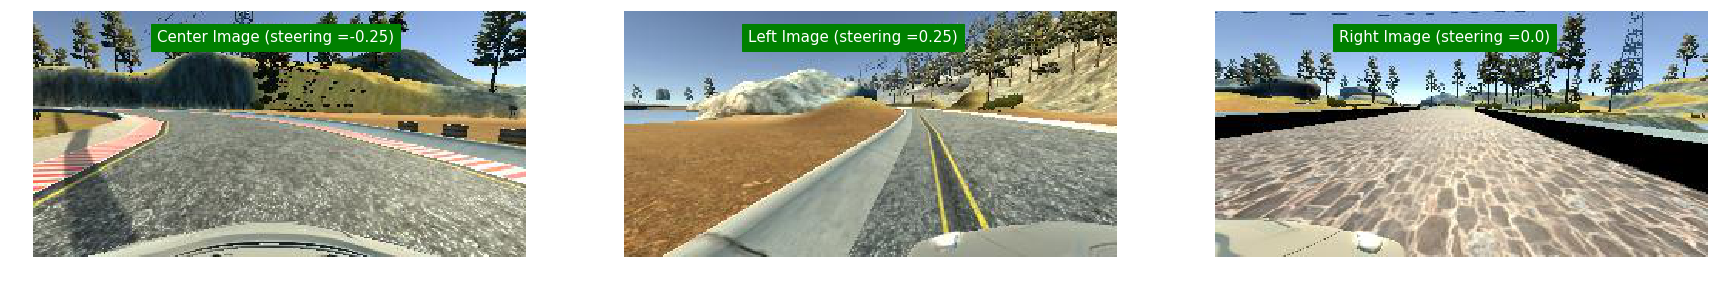

In [2]:
for i in range(0,3):
    random_choose=genran.randint(1, len(driving_csv)-1)
    record=driving_csv.iloc[random_choose]
    of_img=mpimg.imread(record[i])
    plt.subplot(1, 3, i + 1)
    plt.imshow(of_img)
    plt.axis("off")
    plt.text(80, 20,str(record.index[i])+" (steering ="+str(record[3])+")",backgroundcolor='g',color='w',fontsize=15)
        
fig = plt.gcf()
fig.set_size_inches(30, 30)
fig.subplots_adjust(hspace=-.8)
plt.show()

In [3]:
X_train = np.copy(driving_csv['Center Image']+'?'+driving_csv['Left Image']+'?'+driving_csv['Right Image'])
y_train = np.copy(driving_csv['Steering Angle']).astype(np.float32)
# Split data into Train & test data (90%:10%)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# Convert list type into ndarray for analysis convenience
#X_train = np.array(X_train)
#X_test = np.array(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

print("6. Train_Test Split from original dataset:")
print("X_train Shape:",np.array(X_train).shape)
print("y_train Shape:",np.array(y_train).shape)
print("X_eval Shape:",np.array(X_eval).shape)
print("y_eval Shape:",np.array(y_eval).shape)
print("---------------------------------------")

6. Train_Test Split from original dataset:
X_train Shape: (3175,)
y_train Shape: (3175,)
X_eval Shape: (353,)
y_eval Shape: (353,)
---------------------------------------


In [4]:
#Model Initializations in Keras
model = Sequential()
model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(Convolution2D(5, 5, 24, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(5, 5, 36, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(5, 5, 48, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(3, 3, 64, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(3, 3, 64, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(1164))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(100))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(50))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(10))
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(1))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse", metrics=['accuracy'])
model.summary()

train_generator=image_generator(X_train, y_train, rows, cols, channel)
validation_generator=image_generator(X_eval, y_eval, rows, cols, channel)

model.fit_generator(image_generator(X_train, y_train, rows, cols, channel),samples_per_epoch=len(X_train)/batch_size, 
                    nb_epoch=nb_epoch,
                    validation_data=image_generator(X_eval, y_eval, rows, cols, channel),
                   nb_val_samples=int(len(X_train)/batch_size/10))

model_reps = model.to_json()

# Save the trained model
with open(OutputModelJson,'w' ) as f:
    json.dump(model_reps, f)
    model.save_weights(OutputModelH5)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_1 (MaxPooling2D)    (None, 1, 53, 320)    0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 1, 53, 320)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 1, 14, 5)      192005      lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 1, 14, 5)      0           convolution2d_1[0][0]            
___________________________________________________________________________________________

C:\Program Files\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


100/99 [==============================] - 0s - loss: 0.2192 - acc: 0.7200 - val_loss: 0.0577 - val_acc: 0.6667